In [63]:
# Импорт необходимых библиотек.
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Пути до файлов.
folder = os.getcwd()

sql_folder = fr'{folder}\SQL'

files_folder = fr'{folder}\files'
if not os.path.exists(files_folder):
    os.mkdir(files_folder)

db_folder = fr'{folder}\db'
if not os.path.exists(db_folder):
    os.mkdir(db_folder)

db = fr'{folder}\db\testDB.sqlite3'

# Создание подключения к БД.
conn = sqlite3.connect(db)


In [64]:
# SQL запрос для получения продаж из таблицы "Счета".
# Считаю, что, если есть оплаченный счет, то была подтвержденная продажа.
# Сам SQL запрос можно посмотреть в соответствующей папке.
# Берем только одну категорию продукта - "Бухгалтерия.Контур".
sql_sales = fr'{sql_folder}\sales.sql'
sales = open(sql_sales).read()

# Создаем датафрейм, помещаем в него результат выполнения SQL запроса.
df_sales = pd.read_sql_query(sales, conn)
# Преобразуем дату выставления счета и оплаты счета в тип "дата".
df_sales[['BDate', 'PayDate']] = df_sales[['BDate', 'PayDate']].apply(pd.to_datetime)

# Выделяем из даты выставления счета соответствующий месяц для анализа.
df_sales['month_bill'] = df_sales['BDate'].dt.month

# Выделяем из даты выставления счета соответствующий год для анализа.
df_sales['year_bill'] = df_sales['BDate'].dt.year

# Выделяем из даты оплаты счета соответствующий месяц для анализа.
# Заменяем пустые значения на 0.
# Преобразуем к типу "int".
df_sales['month_pay'] = df_sales['PayDate'].dt.month
df_sales['month_pay'].fillna(0, inplace=True)
df_sales['month_pay'] = df_sales['month_pay'].astype('int64')

# Выделяем из даты оплаты счета соответствующий год для анализа.
# Заменяем пустые значения на 0.
# Преобразуем к типу "int".
df_sales['year_pay'] = df_sales['PayDate'].dt.year
df_sales['year_pay'].fillna(0, inplace=True)
df_sales['year_pay'] = df_sales['year_pay'].astype('int64')


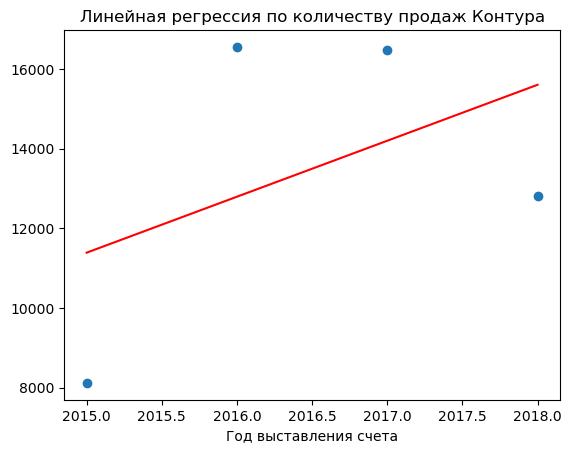

In [65]:
# Датафрейм с количеством продаж по выставленным счетам по году выставления счета.
df_count_by_bill_year = df_sales[['Cost', 'year_bill']].groupby('year_bill')['year_bill'].agg('count')

new = pd.DataFrame({'year':df_count_by_bill_year.index, 'count':df_count_by_bill_year.values})
x = new['year'].values.reshape(-1, 1)
y = new['count'].values.reshape(-1, 1)

# Построим линейную регрессию.
linear_regressor = LinearRegression()
linear_regressor.fit(x, y)
y_pred = linear_regressor.predict(x)

plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.title('Линейная регрессия по количеству продаж Контура')
plt.xlabel('Год выставления счета', horizontalalignment='center')
plt.show()


Исходя из графика линейной регрессии, можно предположить, что количество продаж продуктов Контур будет расти.

In [70]:
# SQL запрос для получения продаж из таблицы "Счета".
# Считаю, что, если есть оплаченный счет, то была подтвержденная продажа.
# Сам SQL запрос можно посмотреть в соответствующей папке.
# В этом запросе берем все категории продуктов.
sql_company = fr'{sql_folder}\by_company_name.sql'
by_company = open(sql_company).read()

# Создаем датафрейм, помещаем в него результат выполнения SQL запроса.
df_by_company = pd.read_sql_query(by_company, conn)
# Преобразуем дату выставления счета и оплаты счета в тип "дата".
df_by_company[['BDate', 'PayDate']] = df_by_company[['BDate', 'PayDate']].apply(pd.to_datetime)

# Запишем датафрейм в csv для анализа либо для построения дашбордов в других системах.
df_by_company.to_csv(fr'{files_folder}\by_company.csv', index=False, sep=';', encoding='utf-8')

df_by_company.head()


,bID,piID,Cost,BDate,PayDate,product,product_company
0,38245F12-1E88-1F03-170E-4C8348BE9100,228,4800.0,2016-06-12,2016-07-05,Контур EDI,Продукт Контура
1,809B23AC-AD38-E99D-5D62-58D2E298E8AF,228,4800.0,2016-04-25,2016-05-19,Контур EDI,Продукт Контура
2,065E5E37-F510-47C1-E008-9CFCAE7C4B15,228,4800.0,2017-10-26,2017-10-29,Контур EDI,Продукт Контура
3,7FE5078D-9B72-409C-3F25-49211729D14E,228,4800.0,2018-09-26,2018-10-28,Контур EDI,Продукт Контура
4,7ABDE9BC-77EB-C0C1-172C-E0142759B9F5,228,4800.0,2016-07-03,2016-07-25,Контур EDI,Продукт Контура


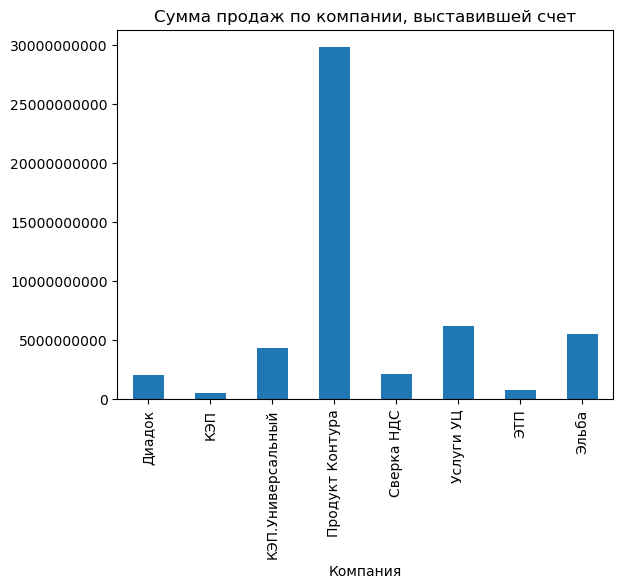

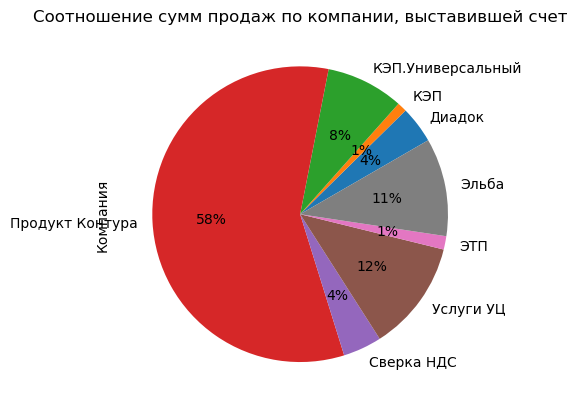

In [79]:
# Создадим датафрейм с суммированием продаж по выставленным счетам.
# По компании, выставившей счет.
df_sum_by_company = df_by_company[['Cost', 'product_company']].groupby('product_company')['Cost'].agg('sum')

# И построим соответствующие графики.
df_sum_by_company.plot(kind = 'bar')
plt.title('Сумма продаж по компании, выставившей счет')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Компания', horizontalalignment='center')
plt.show()

df_sum_by_company.plot(kind='pie', autopct='%1.0f%%', startangle=30)
plt.title('Соотношение сумм продаж по компании, выставившей счет')
plt.ylabel('Компания', horizontalalignment='center')
plt.show()


Исходя из графиков, делаем вывод, что Контур по суммам продаж занимает лидирующие положения. Доля рынка Контура за выбранные годы составляет - 58%.

In [80]:
# Создадим датафрейм по количеству продаж по выставленным счетам.
# По компании, выставившей счет.
df_count_by_company = df_by_company[['Cost', 'product_company']].groupby('product_company')['product_company'].agg('count')

# И построим соответствующие графики.
df_count_by_company.plot(kind = 'bar')
plt.title('Общее количество продаж по компании, выставившей счет'')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Компания', horizontalalignment='center')
plt.show()

df_count_by_company.plot(kind='pie', autopct='%1.0f%%', startangle=30)
plt.title('Соотношение количества продаж продаж по компании, выставившей счет')
plt.ylabel('Компания', horizontalalignment='center')
plt.show()


SyntaxError: unterminated string literal (detected at line 7) (3912078749.py, line 7)

Если говорить о количестве продаж, то и тут Контур занимает лидирующее положение. Доля рынка Контура за выбранные годы составляет - 56%.